# Portfolio

In [69]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import yfinance as yf


In [65]:
stock_return = 8.329
stock_volatility = 12.79

bond_return = 7.48
bond_volatility = 5.78

reit_return = 6.43
reit_volatility = 19.46

gold_return = 16.08
gold_volatility = 17.26

# risk parity
sum_inv_vol = 1/stock_volatility + 1/bond_volatility + 1/reit_volatility + 1/gold_volatility

weights = np.array([
    (1/stock_volatility) / sum_inv_vol,
    (1/bond_volatility) / sum_inv_vol,
    (1/reit_volatility) / sum_inv_vol,
    (1/gold_volatility) / sum_inv_vol
])
weights.round(4)
weights = np.array([0.2, 0.5, 0.15, 0.15])
# weights = np.array([0.25, 0.25, 0.25, 0.25])

returns = np.array([stock_return, bond_return, reit_return, gold_return])
portfolio_return = np.sum(returns * weights)
print(f"Portfolio return: {portfolio_return:.2f}")

volatililties = np.array([stock_volatility, bond_volatility, reit_volatility, gold_volatility])
portfolio_volatility_corr_none = np.sqrt(np.sum(weights * volatililties)**2)
print(f"Portfolio volatility (corr none): {portfolio_volatility_corr_none:.2f}")

rf = 0
sharp_ratio = (portfolio_return - rf) / portfolio_volatility_corr_none
print(f"Sharp ratio: {sharp_ratio:.2f}")


Portfolio return: 8.78
Portfolio volatility (corr none): 10.96
Sharp ratio: 0.80


## データの準備

In [33]:
# stock
# yfinance etf
tickers = yf.Tickers('VTI VGK VPL VWO 2844.T A35.SI 2519.T IYR IFGL GLD JPY=X SGDJPY=X')
historical_data = tickers.history(period='max', interval='1d')
historical_data.reset_index(inplace=True)
etf = pl.DataFrame({
    'date': pl.Series(historical_data['Date']).cast(pl.Date),
    'stock_us': pl.Series(historical_data['Close']['VTI'] * historical_data['Close']['JPY=X']).log().diff(),
    'stock_eu': pl.Series(historical_data['Close']['VGK'] * historical_data['Close']['JPY=X']).log().diff(),
    'stock_ap': pl.Series(historical_data['Close']['VPL'] * historical_data['Close']['JPY=X']).log().diff(),
    'stock_em': pl.Series(historical_data['Close']['VWO'] * historical_data['Close']['JPY=X']).log().diff(),
    'bond_au': pl.Series(historical_data['Close']['2844.T']).log().diff(),
    'bond_sg': pl.Series(historical_data['Close']['A35.SI'] * historical_data['Close']['SGDJPY=X']).log().diff(),
    'bond_d_em': pl.Series(historical_data['Close']['2519.T']).log().diff(),
    'reit_us': pl.Series(historical_data['Close']['IYR'] * historical_data['Close']['JPY=X']).log().diff(),
    'reit_ex_us': pl.Series(historical_data['Close']['IFGL'] * historical_data['Close']['JPY=X']).log().diff(),
    'gold': pl.Series(historical_data['Close']['GLD'] * historical_data['Close']['JPY=X']).log().diff(),
}).drop_nulls()
month_end = etf['date'].dt.month_end().unique()
etf = etf.filter(pl.col('date').is_in(month_end))

etf.head()

[*********************100%***********************]  12 of 12 completed


date,stock_us,stock_eu,stock_ap,stock_em,bond_au,bond_sg,bond_d_em,reit_us,reit_ex_us,gold
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-02-28,-0.000963,-0.023977,-0.007266,-0.011315,0.0,-0.000237,-0.00627,-0.016555,-0.009462,0.010433
2022-03-31,-0.02422,-0.028879,-0.020687,-0.025348,-0.003233,-0.002831,-0.00054,-0.019577,-0.019252,-0.008619
2022-06-30,-0.004681,-0.001876,0.000831,-0.000336,0.004955,0.000163,-0.004381,0.002021,-0.006662,-0.00212
2022-08-31,-0.006381,-0.007735,-0.000562,0.002455,0.0,0.001089,-0.005288,-0.003028,-0.009429,-0.00676
2022-09-30,-0.01344,0.001529,-0.011024,-0.001141,0.010678,0.006801,-0.004254,0.009855,0.023071,0.000293


In [ ]:
# investment trust
investment_trust = pl.read_parquet('../../../../data/raw/investment_trust.parquet')
bond_dev = investment_trust.filter(
    pl.col('investment_trust_association_japan_code') == '0331A172'
)
bond_dev = pl.DataFrame({
    'date': pl.Series(bond_dev['date']).cast(pl.Date),
    'bond_dev': pl.Series(bond_dev['nav']).log().diff(),
}).drop_nulls()

bond_l_em = investment_trust.filter(
    pl.col('investment_trust_association_japan_code') == '0431U169'
)
bond_l_em = pl.DataFrame({
    'date': pl.Series(bond_l_em['date']).cast(pl.Date),
    'bond_l_em': pl.Series(bond_l_em['nav']).log().diff(),
}).drop_nulls()

df = etf.join(bond_dev, on='date', how='inner').join(bond_l_em, on='date', how='inner')

date,stock_us,stock_eu,stock_ap,stock_em,bond_au,bond_sg,bond_d_em,reit_us,reit_ex_us,gold,bond_dev,bond_l_em
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-02-28,-0.000963,-0.023977,-0.007266,-0.011315,0.0,-0.000237,-0.00627,-0.016555,-0.009462,0.010433,-0.002435,-0.005238
2022-03-31,-0.02422,-0.028879,-0.020687,-0.025348,-0.003233,-0.002831,-0.00054,-0.019577,-0.019252,-0.008619,0.003293,0.004746
2022-06-30,-0.004681,-0.001876,0.000831,-0.000336,0.004955,0.000163,-0.004381,0.002021,-0.006662,-0.00212,0.00822,0.003524
2022-08-31,-0.006381,-0.007735,-0.000562,0.002455,0.0,0.001089,-0.005288,-0.003028,-0.009429,-0.00676,-0.000083,-0.001238
2022-09-30,-0.01344,0.001529,-0.011024,-0.001141,0.010678,0.006801,-0.004254,0.009855,0.023071,0.000293,0.006649,0.001921


# risk parity

In [66]:
weights = np.array([
    # stock
    0.06, 0.06, 0.03, 0.05,
    # bond
    0.1, 0.1, 0.15, 0.075, 0.075,
    # reit
    0.0525, 0.0975,
    # gold
    0.15
])
print(f'sum of weights: {np.sum(weights)}')

tmp = np.array([
    df['stock_us'],
    df['stock_eu'],
    df['stock_ap'],
    df['stock_em'],
    df['bond_au'],
    df['bond_sg'],
    df['bond_dev'],
    df['bond_l_em'],
    df['bond_d_em'],
    df['reit_us'],
    df['reit_ex_us'],
    df['gold'],
])

Sigma = np.cov(tmp)
sigma_p = np.sqrt(weights.T @ Sigma @ weights) * np.sqrt(12)
print(f"Portfolio volatility: {sigma_p:.2%}")

sharp_ratio = (portfolio_return - rf) / sigma_p
print(f"Sharp ratio: {sharp_ratio:.2f}")

sum of weights: 1.0
Portfolio volatility: 2.56%
Sharp ratio: 342.52


## Equally weighted portfolio

In [ ]:
weights = np.array([
    # stock
    0.075, 0.075, 0.0375, 0.0625,
    # bond
    0.05, 0.05, 0.075, 0.0375, 0.0375,
    # reit
    0.0875, 0.1625,
    # gold
    0.25
])
print(weights.sum())

tmp = np.array([
    df['stock_us'],
    df['stock_eu'],
    df['stock_ap'],
    df['stock_em'],
    df['bond_au'],
    df['bond_sg'],
    df['bond_dev'],
    df['bond_l_em'],
    df['bond_d_em'],
    df['reit_us'],
    df['reit_ex_us'],
    df['gold'],
])



Sigma = np.cov(tmp)
sigma_p = np.sqrt(weights.T @ Sigma @ weights) * np.sqrt(12)
print(f"Portfolio volatility: {sigma_p:.2%}")

sharp_ratio = (portfolio_return - rf) / sigma_p
print(f"Sharp ratio: {sharp_ratio:.2f}")

1.0
Portfolio volatility: 2.88%
Sharp ratio: 332.47


## Make a Pie chart

Text(0.5, 1.0, 'リスクパリティポートフォリオ')

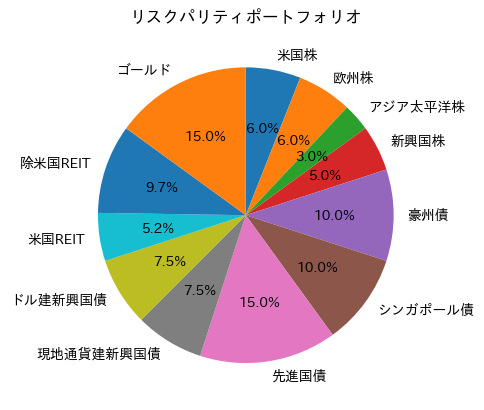

In [88]:
weights_dict = {
    '米国株': 0.06,
    '欧州株': 0.06,
    'アジア太平洋株': 0.03,
    '新興国株': 0.05,
    '豪州債': 0.1,
    'シンガポール債': 0.1,
    '先進国債': 0.15,
    '現地通貨建新興国債': 0.075,
    'ドル建新興国債': 0.075,
    '米国REIT': 0.0525,
    '除米国REIT': 0.0975,
    'ゴールド': 0.15,
}
weights = np.array([
    # stock
    0.06, 0.06, 0.03, 0.05,
    # bond
    0.1, 0.1, 0.15, 0.075, 0.075,
    # reit
    0.0525, 0.0975,
    # gold
    0.15
])

plt.pie(weights, labels=weights_dict.keys(), autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title('リスクパリティポートフォリオ')